In [1]:
# Python Standard Libraries for importing data from binary file
import time    #for calculating time

#core packages
import numpy as np
import matplotlib.pyplot as plt


#custom module
from  dataset import load_dataset, train_dev_split, prep_dataset
from dataset import visualize_data_distribution, visualize_dataset

from ffnn import init_layers, init_hyperParams
from ffnn import train, evaluate

from ModelUtils import  convert_time
from ModelUtils import save_model, load_model

np.random.seed(1)
%matplotlib inline

In [2]:
dataset_size_in_per = 25

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")

Sample Size : 25%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (15000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (15000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (2500, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (2500, 1)


In [3]:
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

print("Data\t\t\t\t","Datatype\t\t","Shape")
print("========================================================================")
print("Training Set Images:\t\t" + str(type(train_x_split))+"\t",str(train_x_split.shape))
print("Training Set Labels:\t\t" + str(type(train_y_split))+"\t",str(train_y_split.shape))
print("Development Set Images:\t\t" + str(type(dev_x_split))+"\t",str(dev_x_split.shape))
print("Development Set Labels:\t\t" + str(type(dev_y_split))+"\t",str(dev_y_split.shape))
print("========================================================================")


Data				 Datatype		 Shape
Training Set Images:		<class 'numpy.ndarray'>	 (12750, 28, 28)
Training Set Labels:		<class 'numpy.ndarray'>	 (12750, 1)
Development Set Images:		<class 'numpy.ndarray'>	 (2250, 28, 28)
Development Set Labels:		<class 'numpy.ndarray'>	 (2250, 1)


In [4]:
train_x_norm, train_y_encoded = prep_dataset(train_x_split, train_y_split, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(12750, 28, 28)		(784, 12750)
Training Set Labels:	(12750, 1)		(10, 12750)
Dev Set Images:		(2250, 28, 28)		(784, 2250)
Dev Set Labels:		(2250, 1)		(10, 2250)
Test Set Images:	(2500, 28, 28)		(784, 2500)
Test Set Labels:	(2500, 1)		(10, 2500)


## Grid Search

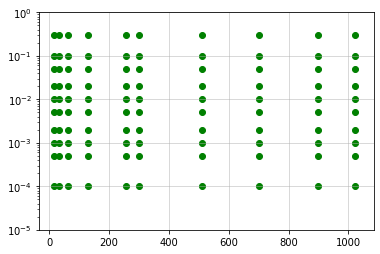

In [5]:
#creating the hyper parameter grid
lr = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.3]
mbz = [16, 32, 64, 128, 256, 300, 512, 700,900,1024]
for i in range(len(mbz)):
    for j in range(len(lr)):
        plt.scatter(mbz[i],lr[j], color = 'g')
plt.yscale('log')
plt.ylim(top = 10e-1, bottom = 10e-6)

plt.grid(alpha = 0.6)


In [6]:
def grid_search(mbz,lr, metric = "acc"):
    
    score = np.zeros((len(mbz),len(lr)))
    toc = time.time()
    
    for ind1 in range(len(mbz)):
        print("\nMinibatch Size: %d"%(mbz[ind1]))
        print("==========================================================================================================")
        
        for ind2 in range(len(lr)):
            print("\nLearning Rate: %.5f"%(lr[ind2]))
            print("-------------------------------")
            
            hyperParams = init_hyperParams(alpha = lr[ind2], num_epoch = 3, minibatch_size = mbz[ind1],lambd = 0.7,keep_probs = [0.8,0.8])
            history = train(train_x_norm, train_y_encoded, dev_x_norm, dev_y_encoded,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = None, verbose = 3)
            
            parameters = history["parameters"]
            
            if metric == "acc": 
                val_acc,_ = evaluate(test_x_norm, test_y_encoded,parameters)
                score[ind1,ind2] = val_acc
                
            elif metric == "f1-score":
                 pass
                
            else:
                raise ValueError("Metric must be 'acc' or 'f1-score'")

        print("==========================================================================================================")
        
    tic = time.time() # for calculating entire search time
    hrs, mins, secs , ms = convert_time((tic - toc)*1000)
    
    print("\n\n*************************** Total Training Time = %dhr %dmins %dsecs %.2fms ***************************"%(hrs, mins, secs, ms))
    
    return score

In [7]:
layers_dim = init_layers(train_x_norm, train_y_encoded, hidden_layers = [256,128])

score = grid_search(mbz,lr, metric = "acc")



Minibatch Size: 16

Learning Rate: 0.00010
-------------------------------
Training The Model...

Epoch 1/3
797/797 [==================== 100%] - 3.33s 4ms/step | loss: 0.7827 | acc: 0.8015 | val_loss: 0.3929 | val_acc: 0.8902
Epoch 2/3
797/797 [==================== 100%] - 3.33s 4ms/step | loss: 0.2967 | acc: 0.9190 | val_loss: 0.3029 | val_acc: 0.9107
Epoch 3/3
797/797 [==================== 100%] - 3.32s 4ms/step | loss: 0.2283 | acc: 0.9365 | val_loss: 0.2646 | val_acc: 0.9249

Total Training Time = 0hr 0mins 11secs 632.01ms

Learning Rate: 0.00050
-------------------------------
Training The Model...

Epoch 1/3
797/797 [==================== 100%] - 3.33s 4ms/step | loss: 0.3728 | acc: 0.8977 | val_loss: 0.2400 | val_acc: 0.9311
Epoch 2/3
797/797 [==================== 100%] - 3.51s 4ms/step | loss: 0.1470 | acc: 0.9595 | val_loss: 0.1919 | val_acc: 0.9427
Epoch 3/3
797/797 [==================== 100%] - 3.36s 4ms/step | loss: 0.0906 | acc: 0.9758 | val_loss: 0.1628 | val_acc: 0.9551

/home/befrenz/Sameer Kattel/Education/Course/CSIT/7th Semester/Project Work/HandWritten-Digit-Recognition-using-Deep-Learning/9. Final Project/ModelUtils.py:121: RuntimeWarning: invalid value encountered in true_divide
  A = np.divide(t, np.sum(t, axis=0))
/home/befrenz/Sameer Kattel/Education/Course/CSIT/7th Semester/Project Work/HandWritten-Digit-Recognition-using-Deep-Learning/9. Final Project/ModelUtils.py:86: RuntimeWarning: invalid value encountered in less_equal
  dZ[Z <= 0] = 0  # implementing integrated form of (gradiant of ReLU function * gradient of the loss function)


797/797 [==================== 100%] - 3.57s 4ms/step | loss: nan | acc: 0.1836 | val_loss: nan | val_acc: 0.1040
Epoch 3/3
797/797 [==================== 100%] - 3.84s 4ms/step | loss: nan | acc: 0.0971 | val_loss: nan | val_acc: 0.1040

Total Training Time = 0hr 0mins 13secs 70.65ms

Learning Rate: 0.10000
-------------------------------
Training The Model...

Epoch 1/3
797/797 [==================== 100%] - 3.82s 4ms/step | loss: 2.3121 | acc: 0.1517 | val_loss: 2.3383 | val_acc: 0.0996
Epoch 2/3
797/797 [==================== 100%] - 3.38s 4ms/step | loss: 2.3142 | acc: 0.1084 | val_loss: 2.3104 | val_acc: 0.1160
Epoch 3/3
797/797 [==================== 100%] - 3.34s 4ms/step | loss: 2.3084 | acc: 0.1140 | val_loss: 2.3133 | val_acc: 0.0960

Total Training Time = 0hr 0mins 12secs 264.01ms

Learning Rate: 0.30000
-------------------------------
Training The Model...

Epoch 1/3
797/797 [==================== 100%] - 3.34s 4ms/step | loss: nan | acc: 0.0971 | val_loss: nan | val_acc: 0.1040

200/200 [==================== 100%] - 1.30s 6ms/step | loss: 0.1589 | acc: 0.9559 | val_loss: 0.1951 | val_acc: 0.9404
Epoch 3/3
200/200 [==================== 100%] - 1.23s 6ms/step | loss: 0.1001 | acc: 0.9731 | val_loss: 0.1763 | val_acc: 0.9520

Total Training Time = 0hr 0mins 4secs 527.82ms

Learning Rate: 0.00200
-------------------------------
Training The Model...

Epoch 1/3
200/200 [==================== 100%] - 1.09s 5ms/step | loss: 0.3255 | acc: 0.9091 | val_loss: 0.2207 | val_acc: 0.9360
Epoch 2/3
200/200 [==================== 100%] - 1.11s 5ms/step | loss: 0.1219 | acc: 0.9666 | val_loss: 0.1809 | val_acc: 0.9444
Epoch 3/3
200/200 [==================== 100%] - 1.08s 5ms/step | loss: 0.0707 | acc: 0.9824 | val_loss: 0.1718 | val_acc: 0.9547

Total Training Time = 0hr 0mins 4secs 15.70ms

Learning Rate: 0.00500
-------------------------------
Training The Model...

Epoch 1/3
200/200 [==================== 100%] - 1.13s 5ms/step | loss: 0.2691 | acc: 0.9255 | val_loss: 0.2055 |

100/100 [==================== 100%] - 0.64s 6ms/step | loss: 1.6931 | acc: 0.5608 | val_loss: 1.1360 | val_acc: 0.5396
Epoch 2/3
100/100 [==================== 100%] - 0.65s 6ms/step | loss: 0.8670 | acc: 0.6650 | val_loss: 0.8477 | val_acc: 0.7218
Epoch 3/3
100/100 [==================== 100%] - 0.78s 7ms/step | loss: 0.6558 | acc: 0.7573 | val_loss: 0.7352 | val_acc: 0.7591

Total Training Time = 0hr 0mins 2secs 624.28ms

Learning Rate: 0.30000
-------------------------------
Training The Model...

Epoch 1/3
100/100 [==================== 100%] - 0.70s 6ms/step | loss: nan | acc: 0.0976 | val_loss: nan | val_acc: 0.1040
Epoch 2/3
100/100 [==================== 100%] - 0.62s 6ms/step | loss: nan | acc: 0.0973 | val_loss: nan | val_acc: 0.1040
Epoch 3/3
100/100 [==================== 100%] - 0.62s 6ms/step | loss: nan | acc: 0.0969 | val_loss: nan | val_acc: 0.1040

Total Training Time = 0hr 0mins 2secs 447.39ms

Minibatch Size: 256

Learning Rate: 0.00010
-------------------------------
Tr

43/43 [==================== 100%] - 0.44s 10ms/step | loss: 0.1939 | acc: 0.9431 | val_loss: 0.2292 | val_acc: 0.9342
Epoch 3/3
43/43 [==================== 100%] - 0.44s 10ms/step | loss: 0.1294 | acc: 0.9636 | val_loss: 0.1935 | val_acc: 0.9418

Total Training Time = 0hr 0mins 1secs 845.86ms

Learning Rate: 0.00500
-------------------------------
Training The Model...

Epoch 1/3
43/43 [==================== 100%] - 0.46s 10ms/step | loss: 0.3812 | acc: 0.8885 | val_loss: 0.2529 | val_acc: 0.9271
Epoch 2/3
43/43 [==================== 100%] - 0.44s 10ms/step | loss: 0.1495 | acc: 0.9574 | val_loss: 0.1825 | val_acc: 0.9498
Epoch 3/3
43/43 [==================== 100%] - 0.45s 10ms/step | loss: 0.0836 | acc: 0.9775 | val_loss: 0.1652 | val_acc: 0.9489

Total Training Time = 0hr 0mins 1secs 875.15ms

Learning Rate: 0.01000
-------------------------------
Training The Model...

Epoch 1/3
43/43 [==================== 100%] - 0.43s 10ms/step | loss: 0.4345 | acc: 0.8634 | val_loss: 0.2451 | val_

25/25 [==================== 100%] - 0.31s 12ms/step | loss: nan | acc: 0.0962 | val_loss: nan | val_acc: 0.1040
Epoch 2/3
25/25 [==================== 100%] - 0.31s 12ms/step | loss: nan | acc: 0.0971 | val_loss: nan | val_acc: 0.1040
Epoch 3/3
25/25 [==================== 100%] - 0.31s 12ms/step | loss: nan | acc: 0.0971 | val_loss: nan | val_acc: 0.1040

Total Training Time = 0hr 0mins 1secs 302.31ms

Minibatch Size: 700

Learning Rate: 0.00010
-------------------------------
Training The Model...

Epoch 1/3
19/19 [==================== 100%] - 0.35s 18ms/step | loss: 2.1457 | acc: 0.2431 | val_loss: 1.9672 | val_acc: 0.4356
Epoch 2/3
19/19 [==================== 100%] - 0.35s 18ms/step | loss: 1.7862 | acc: 0.5902 | val_loss: 1.6202 | val_acc: 0.6884
Epoch 3/3
19/19 [==================== 100%] - 0.34s 18ms/step | loss: 1.4308 | acc: 0.7392 | val_loss: 1.2828 | val_acc: 0.7644

Total Training Time = 0hr 0mins 1secs 499.34ms

Learning Rate: 0.00050
-------------------------------
Training

15/15 [==================== 100%] - 0.31s 20ms/step | loss: 0.2399 | acc: 0.9302 | val_loss: 0.2450 | val_acc: 0.9289
Epoch 3/3
15/15 [==================== 100%] - 0.34s 22ms/step | loss: 0.1616 | acc: 0.9530 | val_loss: 0.2115 | val_acc: 0.9373

Total Training Time = 0hr 0mins 1secs 412.61ms

Learning Rate: 0.01000
-------------------------------
Training The Model...

Epoch 1/3
15/15 [==================== 100%] - 0.31s 20ms/step | loss: 0.7730 | acc: 0.7601 | val_loss: 0.3943 | val_acc: 0.8853
Epoch 2/3
15/15 [==================== 100%] - 0.31s 20ms/step | loss: 0.2371 | acc: 0.9287 | val_loss: 0.2553 | val_acc: 0.9240
Epoch 3/3
15/15 [==================== 100%] - 0.31s 20ms/step | loss: 0.1531 | acc: 0.9529 | val_loss: 0.2082 | val_acc: 0.9400

Total Training Time = 0hr 0mins 1secs 350.82ms

Learning Rate: 0.02000
-------------------------------
Training The Model...

Epoch 1/3
15/15 [==================== 100%] - 0.30s 19ms/step | loss: 1.6118 | acc: 0.6227 | val_loss: 0.5319 | val_

In [8]:
print(score)
print(np.where(score == np.max(score)))

[[0.928  0.9568 0.9564 0.9616 0.9532 0.9256 0.9036 0.0876 0.1032 0.0876]
 [0.918  0.9512 0.9596 0.958  0.9472 0.9352 0.9132 0.8676 0.268  0.0876]
 [0.9092 0.9436 0.9592 0.9576 0.9536 0.9264 0.9332 0.912  0.302  0.0876]
 [0.8976 0.9368 0.95   0.958  0.9572 0.9396 0.9436 0.8848 0.7588 0.0876]
 [0.8728 0.922  0.9368 0.9488 0.9532 0.948  0.9452 0.9124 0.6904 0.0876]
 [0.866  0.9212 0.932  0.9488 0.9596 0.952  0.9508 0.9152 0.4648 0.0876]
 [0.8152 0.9112 0.926  0.9348 0.9472 0.9504 0.9376 0.9144 0.5296 0.0876]
 [0.7704 0.9004 0.9192 0.9312 0.944  0.9452 0.9372 0.894  0.4832 0.0876]
 [0.7372 0.896  0.9084 0.922  0.9372 0.946  0.9344 0.8592 0.398  0.0876]
 [0.7024 0.8892 0.9096 0.9256 0.942  0.9424 0.9364 0.8568 0.4416 0.0876]]
(array([0]), array([3]))


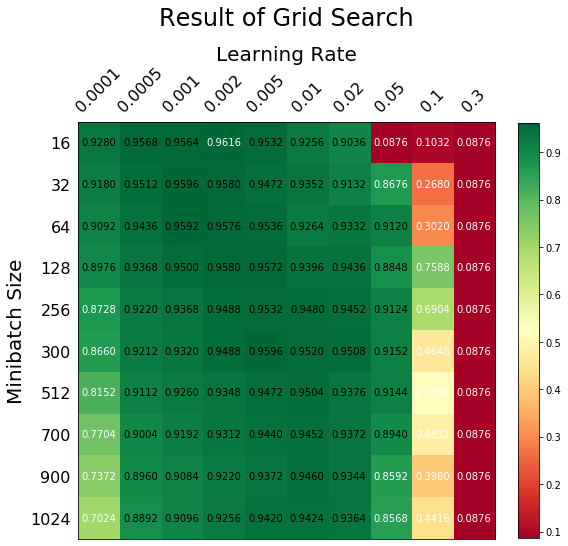

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
im = plt.imshow(score,cmap="RdYlGn") #RdYlGn, PiYG, Accent,Blues,viridis, YlGnBu
fig.colorbar(im,ax=ax,fraction=0.045)

m = len(lr)
n = len(mbz)
    
ax.set_title("Result of Grid Search",fontsize=24,pad = 20)
ax.set_xticks(range(0,m))
ax.set_yticks(range(0,n))
ax.set_xlabel("Learning Rate", fontsize = 20)
ax.set_ylabel("Minibatch Size", fontsize = 20)

ax.set_xticklabels(lr,fontsize=16,rotation=45)
ax.set_yticklabels(mbz,fontsize=16)

#setting horizontal axes labeling to top.
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')


# Turn off all the ticks
ax.tick_params(top=False,left=False)


thres = [0.88, 0.96]

for i in range(n):
    for j in range(m):
        ax.text(j, i, "%.4f"%(score[i, j]),
                       ha="center", va="center", color="w" if score[i,j] > thres[1] or score[i,j] < thres[0]  else "black")


fig.tight_layout()
plt.show()
